<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

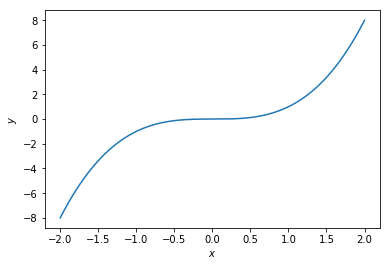

In [16]:
X = np.linspace(-2, 2, 300)

y = X ** 3

plt.plot(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

-1.8947806286936006e-16


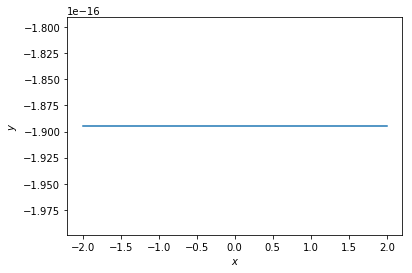

In [17]:
# Ваш код здесь
y1 = np.mean(y)
print( y1)
plt.plot(X, [y1]*X.shape[0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

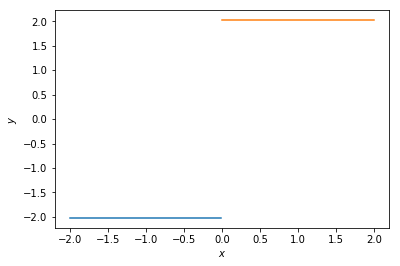

In [18]:
# Ваш код здесь

X_left = X[X<0]
y_left = X_left ** 3

X_right = X[~(X<0)]
y_right = X_right ** 3


plt.plot(X_left, [np.mean(y_left)]*X_left.shape[0])
plt.plot(X_right, [np.mean(y_right)]*X_right.shape[0])

plt.xlabel(r'$x$')
plt.ylabel(r'$y$');


В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. <font color="red">При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.</font>

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [19]:
def var(X, y):
    l = X.shape[0]
    one = (1/l)*np.sum(y)
    s = 0
    for i in range(len(y)):
        s += (y[i]-one)**2
    return (1/l)*s



def regression_var_criterion(X, y, t):
    DX = np.var(y)
    #print(DX)
    #print('VS')
    #print(var(X,y))
    X_l = y[X<t]
    X_r = y[~(X<t)]
    capacity_X = X.shape[0]
    capacity_X_l = X_l.shape[0]
    capacity_X_r = X_r.shape[0]
    return DX - (capacity_X_l/capacity_X)*np.var(X_l) - (capacity_X_r/capacity_X)*np.var(X_r)

In [20]:
# Ваш код здесь
X_var = np.linspace(-1.9, 1.9, 100)

vals = []

for t in X_var:
    vals.append(regression_var_criterion(X, y, t))

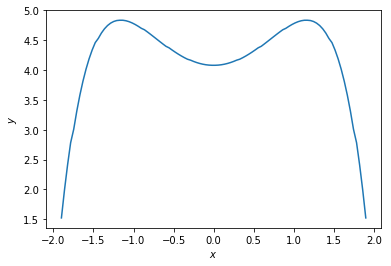

In [21]:
plt.plot(X_var, vals)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- --->Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

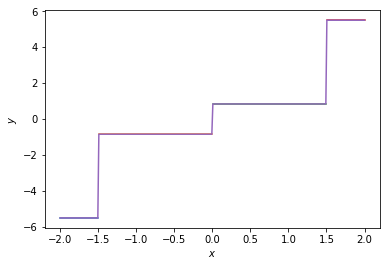

In [8]:
# Ваш код здесь
#X_left
X_left_l = X_left[X_left<-1.5]
y_left_l = X_left_l ** 3
y1 = [np.mean(y_left_l)]*X_left_l.shape[0]
plt.plot(X_left_l, y1)


X_left_r = X_left[~(X_left<-1.5)]
y_left_r = X_left_r ** 3
y2 = [np.mean(y_left_r)]*X_left_r.shape[0]
plt.plot(X_left_r, [np.mean(y_left_r)]*X_left_r.shape[0])

#X_right
X_right_l = X_right[X_right<1.5]
y_right_l = X_right_l ** 3
y3 = [np.mean(y_right_l)]*X_right_l.shape[0]
plt.plot(X_right_l, [np.mean(y_right_l)]*X_right_l.shape[0])



X_right_r = X_right[~(X_right<1.5)]
y_right_r = X_right_r ** 3
y4 = [np.mean(y_right_r)]*X_right_r.shape[0]
plt.plot(X_right_r, [np.mean(y_right_r)]*X_right_r.shape[0])


resX = np.concatenate((X_left_l,X_left_r, X_right_l, X_right_r))
resy = np.concatenate((y1,y2,y3,y4))
 
plt.plot(resX, resy)
#plt.plot(X_right, [np.mean(y_right)]*X_right.shape[0])

plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- -->7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [9]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [10]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [11]:
# Ваш код здесь

df['age_years'] = (round(df['age']/365.25)).astype('int64')
 
level_dic = {1:'norm', 2:'high', 3:'higest'}
df['cholesterol_dec'] = (df['cholesterol'].map(level_dic)).astype('object')
df['gluc_dec'] = (df['gluc'].map(level_dic)).astype('object')

df2 = df.join(pd.get_dummies(df['gluc_dec'], prefix='gluc'))
df2 = df2.join(pd.get_dummies(df['cholesterol_dec'], prefix='chol'))

cols_for_remove = ['cholesterol_dec', 'gluc_dec', 'gluc','cholesterol', 'cardio']

res_cols = list(set(df2.columns.values.tolist()) - set(cols_for_remove))

print(res_cols)
df2[res_cols].head()

#non_categorical_cols = list(set(data.columns.values.tolist()) - set(categorical_cols) - set(for_remove))


['ap_lo', 'gluc_higest', 'ap_hi', 'smoke', 'gender', 'chol_norm', 'weight', 'height', 'chol_higest', 'gluc_norm', 'gluc_high', 'chol_high', 'age_years', 'alco', 'active', 'age']


,ap_lo,gluc_higest,ap_hi,smoke,gender,chol_norm,weight,height,chol_higest,gluc_norm,gluc_high,chol_high,age_years,alco,active,age
id,,,,,,,,,,,,,,,,
0,80,0,110,0,2,1,62.0,168,0,1,0,0,50,0,1,18393
1,90,0,140,0,1,0,85.0,156,1,1,0,0,55,0,1,20228
2,70,0,130,0,1,0,64.0,165,1,1,0,0,52,0,0,18857
3,100,0,150,0,2,1,82.0,169,0,1,0,0,48,0,1,17623
4,60,0,100,0,1,1,56.0,156,0,1,0,0,48,0,0,17474


In [12]:
df2.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,cardio,age_years,cholesterol_dec,gluc_dec,gluc_higest,gluc_high,gluc_norm,chol_higest,chol_high,chol_norm
id,,,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,...,0,50,norm,norm,0,0,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,...,1,55,higest,norm,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,...,1,52,higest,norm,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,...,1,48,norm,norm,0,0,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,...,0,48,norm,norm,0,0,1,0,0,1


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [13]:
y = df2['cardio'].astype('int')
X = df2[res_cols]

X.head()

,ap_lo,gluc_higest,ap_hi,smoke,gender,chol_norm,weight,height,chol_higest,gluc_norm,gluc_high,chol_high,age_years,alco,active,age
id,,,,,,,,,,,,,,,,
0,80,0,110,0,2,1,62.0,168,0,1,0,0,50,0,1,18393
1,90,0,140,0,1,0,85.0,156,1,1,0,0,55,0,1,20228
2,70,0,130,0,1,0,64.0,165,1,1,0,0,52,0,0,18857
3,100,0,150,0,2,1,82.0,169,0,1,0,0,48,0,1,17623
4,60,0,100,0,1,1,56.0,156,0,1,0,0,48,0,0,17474


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                      shuffle=True, random_state=17)
# Ваш код здесь

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [15]:
# Ваш код здесь

tree = DecisionTreeClassifier(max_depth=3, random_state=17)

tree.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [16]:
export_graphviz(tree, out_file='tree.dot', feature_names=X.columns, filled=True)

In [17]:
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('somefile.png')

<img src="somefile.png"></img>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- --->age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [18]:
# Ваш код здесь
tree_valid_pred = tree.predict(X_valid)
round(float(accuracy_score(y_valid, tree_valid_pred)), 3)

0.721

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [19]:
tree_params = {'max_depth': list(range(2, 11, ))}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
tree_grid = GridSearchCV(estimator=tree, param_grid=tree_params, cv=skf, verbose=True)

In [20]:
%%time
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 3.38 s, sys: 20 ms, total: 3.4 s
Wall time: 3.4 s


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [21]:
tree_grid.best_params_

#tree_grid.grid_scores_

{'max_depth': 4}

In [22]:
tree_grid.best_score_

0.7304285714285714

In [23]:
tree_grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


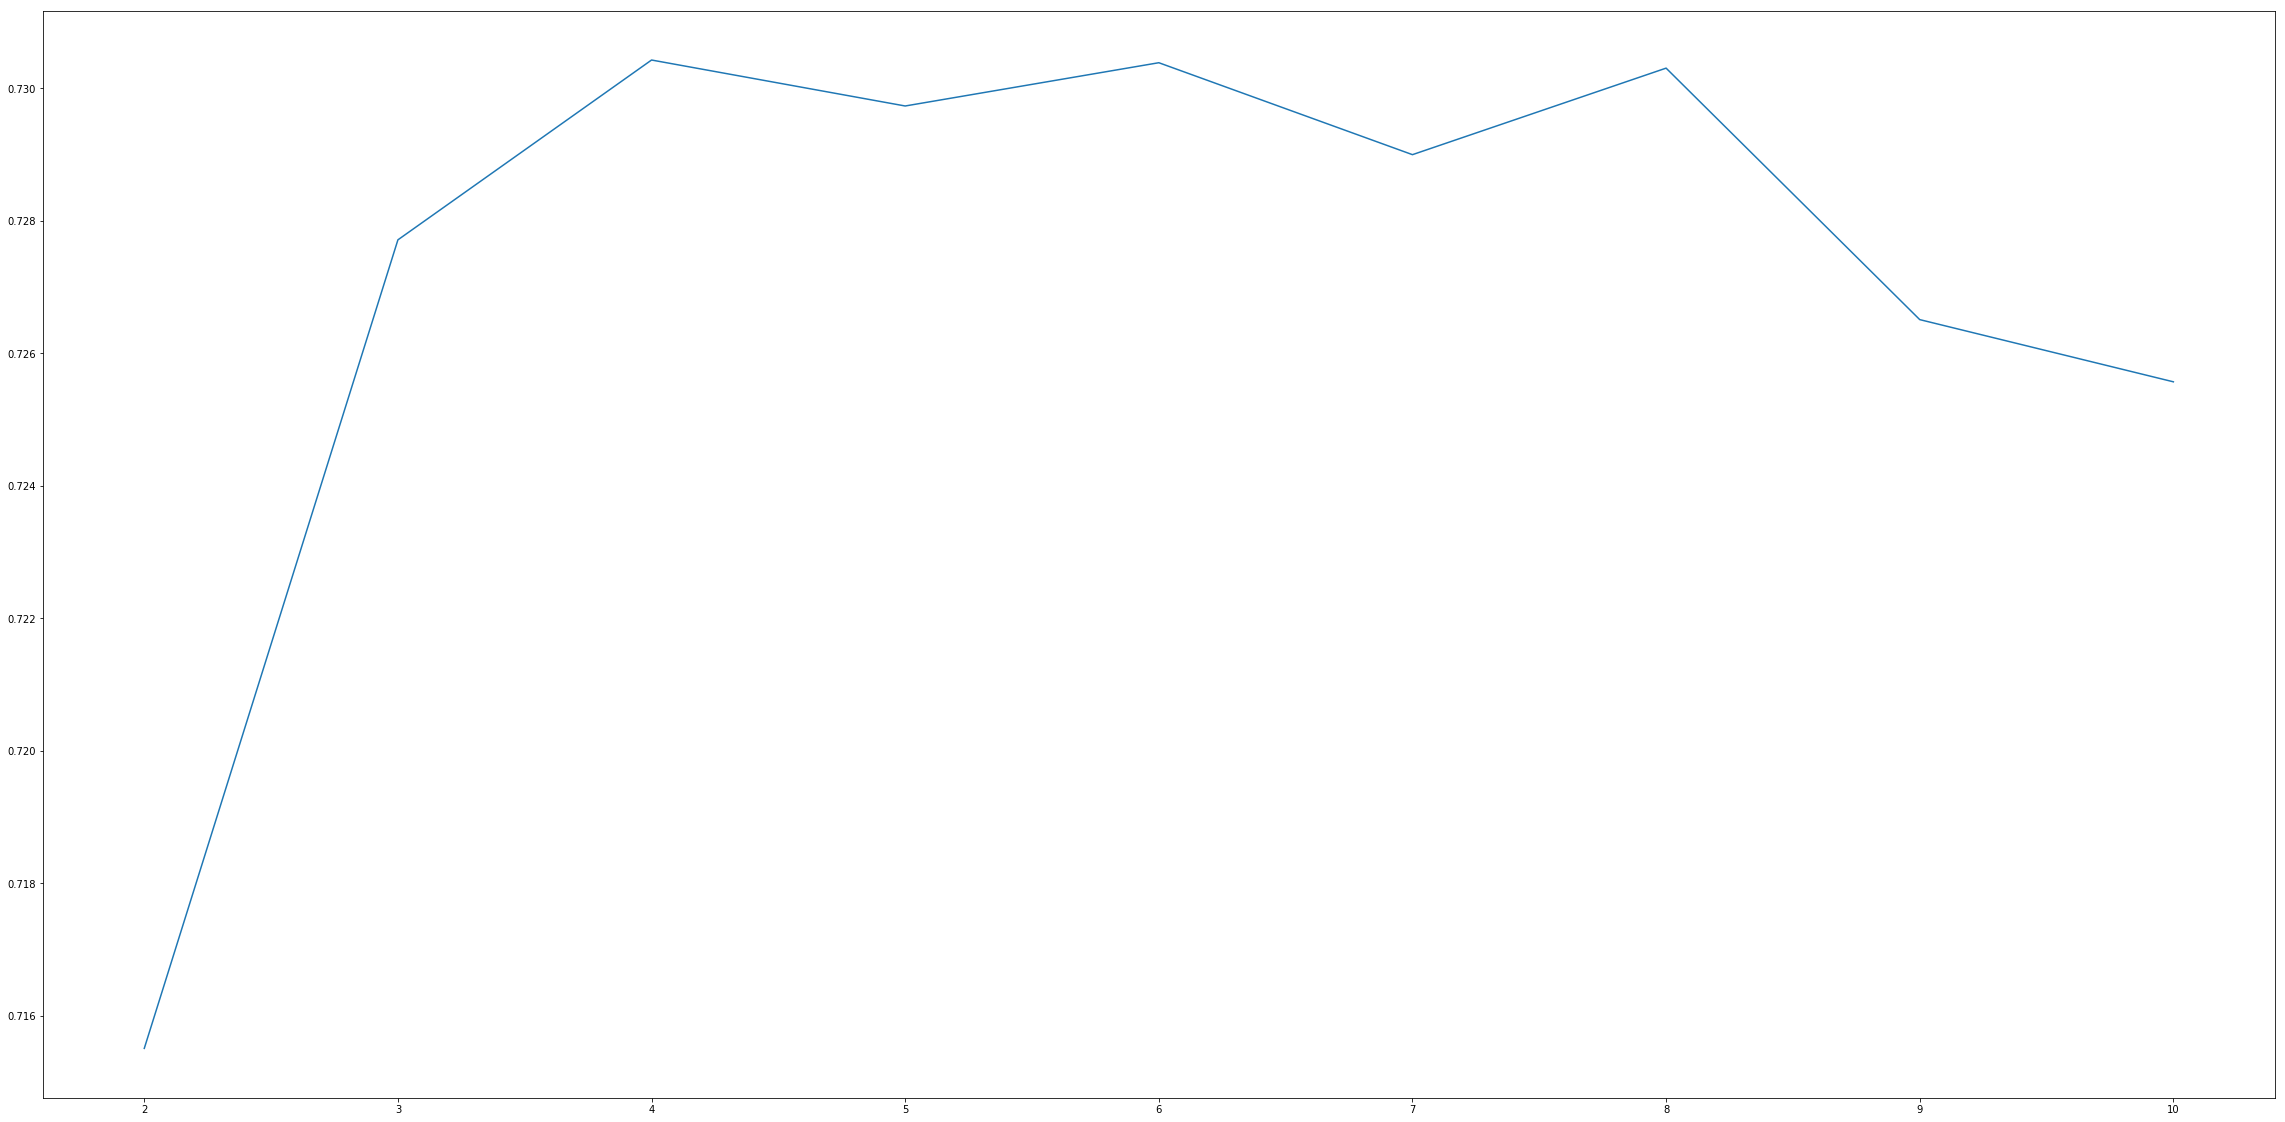

In [47]:
# Ваш код здесь
#from sklearn.model_selection import cross_val_score

#print(accuracy_score(y_valid, tree_grid.predict(X_valid)))
#vs
#print(np.mean(cross_val_score(tree_grid.best_estimator_, X_train, y_train, cv=5)))

#print((tree_grid.cv_results_['split0_test_score']))
#print(tree_grid.grid_scores_)

#scores1 = tree_grid.cv_results_['mean_test_score']
#print(scores1)
scores = [x[1] for x in tree_grid.grid_scores_]
#print(scores)
plt.figure(figsize=(40,20))

plt.plot(range(2,11), scores)
plt.show()

#for i in range(0,len(tree_grid.grid_scores_)):
#    print(tree_grid.cv_results_[i][0]['max_depth'])
#    #[1][0]['max_depth']

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [31]:
# Ваш код здесь
acc2 = tree_grid.best_score_
acc1 = round(float(accuracy_score(y_valid, tree_valid_pred)), 3)
print(acc1)
print(acc2)
print(((acc2 - acc1) / acc1) * 100)

0.721
0.7304285714285714
1.3077075490390364


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- --->да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)
Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. 

In [40]:
df2[res_cols].head()
gender_dic = {1:0, 2:1}
df2['male'] = (df['gender'].map(gender_dic)).astype('object')

df2['age_45_50'] = df2.age_years.apply(lambda x: 1 if x >= 45 | x <50 else 0)
df2['age_50_55'] = df2.age_years.apply(lambda x: 1 if x >= 50 | x <55 else 0)
df2['age_55_60'] = df2.age_years.apply(lambda x: 1 if x >= 55 | x <60 else 0)
df2['age_60_65'] = df2.age_years.apply(lambda x: 1 if x >= 60 | x <65 else 0)


df2['ap_hi_120_140'] = df2.ap_hi.apply(lambda x: 1 if x >= 120 | x <140 else 0)
df2['ap_hi_140_160'] = df2.ap_hi.apply(lambda x: 1 if x >= 140 | x <160 else 0)
df2['ap_hi_160_180'] = df2.ap_hi.apply(lambda x: 1 if x >= 160 | x <180 else 0)


cols_for_using = ['male', 'smoke','chol_norm','chol_high','chol_higest',
                  'age_45_50','age_50_55','age_55_60','age_60_65',
                 'ap_hi_120_140','ap_hi_140_160','ap_hi_160_180']
df2[cols_for_using].head()

,male,smoke,chol_norm,chol_high,chol_higest,age_45_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180
id,,,,,,,,,,,,
0,1,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0


 Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- --?Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [41]:
# Ваш код здесь
X_last = df2[cols_for_using]
tree_last = DecisionTreeClassifier(max_depth=3, random_state=17)

tree_last.fit(X_last, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [42]:
export_graphviz(tree_last, out_file='tree_last.dot', feature_names=X_last.columns, filled=True)

In [43]:
(graph,) = pydot.graph_from_dot_file('tree_last.dot')
graph.write_png('somefile_last.png')

<img src="somefile_last.png"></img>